In [1]:
#Import necessary functions
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import folium


#For Time Series 
from datetime import datetime as dt
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error


%matplotlib inline

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/Final_Motor_Vehicle_Collisions_QuBr_2018-2023_V1.csv')
df.head()

,CRASH DATE TIME,COLLISION_ID,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,CONTRIBUTING FACTOR VEHICLE 1,VEHICLE TYPE CODE 1,CONTRIBUTING CATEGORY V1,SEASON,TIME OF DAY,IS RUSH HOUR
0,2018-01-01 00:00:00,3820851,BROOKLYN,11239,40.65306,-73.88202,0,0,Driver Inattention/Distraction,Sedan,Driver Error,Winter,Late Night,False
1,2018-01-01 00:00:00,3820945,BROOKLYN,11234,40.62877,-73.91825,1,0,Failure to Yield Right-of-Way,Sedan,Moving Violation,Winter,Late Night,False
2,2018-01-01 00:00:00,3819067,QUEENS,11419,40.68297,-73.82824,0,0,Passing Too Closely,Sedan,Moving Violation,Winter,Late Night,False
3,2018-01-01 00:00:00,3822296,BROOKLYN,11230,40.62418,-73.97048,0,0,Driver Inattention/Distraction,Station Wagon/Sport Utility Vehicle,Driver Error,Winter,Late Night,False
4,2018-01-01 00:00:00,3821055,BROOKLYN,11230,40.62322,-73.96102,0,0,Driver Inattention/Distraction,Taxi,Driver Error,Winter,Late Night,False


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213962 entries, 0 to 213961
Data columns (total 14 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CRASH DATE TIME                213962 non-null  object 
 1   COLLISION_ID                   213962 non-null  int64  
 2   BOROUGH                        213962 non-null  object 
 3   ZIP CODE                       213962 non-null  int64  
 4   LATITUDE                       213962 non-null  float64
 5   LONGITUDE                      213962 non-null  float64
 6   NUMBER OF PERSONS INJURED      213962 non-null  int64  
 7   NUMBER OF PERSONS KILLED       213962 non-null  int64  
 8   CONTRIBUTING FACTOR VEHICLE 1  213962 non-null  object 
 9   VEHICLE TYPE CODE 1            213962 non-null  object 
 10  CONTRIBUTING CATEGORY V1       213962 non-null  object 
 11  SEASON                         213962 non-null  object 
 12  TIME OF DAY                   

#### Changing DateTime Index

In [4]:
#Change column to datetime datatype
df['CRASH DATE TIME'] = pd.to_datetime(df['CRASH DATE TIME'])

In [5]:
ts = df.copy()
ts.head()

,CRASH DATE TIME,COLLISION_ID,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,CONTRIBUTING FACTOR VEHICLE 1,VEHICLE TYPE CODE 1,CONTRIBUTING CATEGORY V1,SEASON,TIME OF DAY,IS RUSH HOUR
0,2018-01-01,3820851,BROOKLYN,11239,40.65306,-73.88202,0,0,Driver Inattention/Distraction,Sedan,Driver Error,Winter,Late Night,False
1,2018-01-01,3820945,BROOKLYN,11234,40.62877,-73.91825,1,0,Failure to Yield Right-of-Way,Sedan,Moving Violation,Winter,Late Night,False
2,2018-01-01,3819067,QUEENS,11419,40.68297,-73.82824,0,0,Passing Too Closely,Sedan,Moving Violation,Winter,Late Night,False
3,2018-01-01,3822296,BROOKLYN,11230,40.62418,-73.97048,0,0,Driver Inattention/Distraction,Station Wagon/Sport Utility Vehicle,Driver Error,Winter,Late Night,False
4,2018-01-01,3821055,BROOKLYN,11230,40.62322,-73.96102,0,0,Driver Inattention/Distraction,Taxi,Driver Error,Winter,Late Night,False


# QUEENS ONLY

In [6]:
queens = df.copy()
queens = queens.loc[queens['BOROUGH'] == 'QUEENS']
queens

,CRASH DATE TIME,COLLISION_ID,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,CONTRIBUTING FACTOR VEHICLE 1,VEHICLE TYPE CODE 1,CONTRIBUTING CATEGORY V1,SEASON,TIME OF DAY,IS RUSH HOUR
2,2018-01-01 00:00:00,3819067,QUEENS,11419,40.682970,-73.828240,0,0,Passing Too Closely,Sedan,Moving Violation,Winter,Late Night,False
7,2018-01-01 00:27:00,3821878,QUEENS,11419,40.689133,-73.820860,0,0,Failure to Yield Right-of-Way,Sedan,Moving Violation,Winter,Late Night,False
8,2018-01-01 00:27:00,4025420,QUEENS,11419,40.689133,-73.820860,0,0,Failure to Yield Right-of-Way,Sedan,Moving Violation,Winter,Late Night,False
10,2018-01-01 00:47:00,3819950,QUEENS,11433,40.702690,-73.781450,0,0,Unsafe Speed,Sedan,Moving Violation,Winter,Late Night,False
13,2018-01-01 00:58:00,3819961,QUEENS,11411,40.693160,-73.733800,0,0,Unsafe Speed,Station Wagon/Sport Utility Vehicle,Moving Violation,Winter,Late Night,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213953,2022-12-31 21:00:00,4594302,QUEENS,11355,40.757164,-73.822120,1,0,Failure to Yield Right-of-Way,Station Wagon/Sport Utility Vehicle,Moving Violation,Winter,Night,False
213955,2022-12-31 21:20:00,4596703,QUEENS,11106,40.759884,-73.936800,1,0,Failure to Yield Right-of-Way,Sedan,Moving Violation,Winter,Night,False
213957,2022-12-31 22:02:00,4594338,QUEENS,11102,40.766150,-73.919785,2,0,Following Too Closely,Sedan,Moving Violation,Winter,Night,False
213959,2022-12-31 23:20:00,4594416,QUEENS,11369,40.760098,-73.859300,2,0,Alcohol Involvement,Station Wagon/Sport Utility Vehicle,Bodily Impairment,Winter,Night,False


### Groupby Daily

In [7]:
#Group the values by day and count the number of instances of each value
queens_count = queens.groupby([df['CRASH DATE TIME'].dt.date, 'CONTRIBUTING CATEGORY V1']).size().reset_index(name='count')

#Print the result
print(queens_count)

     CRASH DATE TIME CONTRIBUTING CATEGORY V1  count
0         2018-01-01        Bodily Impairment      2
1         2018-01-01             Driver Error     17
2         2018-01-01         Moving Violation     38
3         2018-01-01       Other Distractions      1
4         2018-01-01          Road Conditions      3
...              ...                      ...    ...
9840      2022-12-31        Bodily Impairment      4
9841      2022-12-31             Driver Error     15
9842      2022-12-31    Environmental Factors      2
9843      2022-12-31         Moving Violation     23
9844      2022-12-31  Third-Party (Vehicular)      1

[9845 rows x 3 columns]


In [8]:
#Create pivot table of daily cause categories
queens_pivt = queens_count.pivot(index='CRASH DATE TIME', columns='CONTRIBUTING CATEGORY V1', values='count').fillna(0)
queens_pivt.head(10)

CONTRIBUTING CATEGORY V1,Bodily Impairment,Driver Error,Environmental Factors,Internal Electronics Usage,Moving Violation,Other Distractions,Road Conditions,Third-Party (Non-Vehicular),Third-Party (Vehicular),Vehicle Defects
CRASH DATE TIME,,,,,,,,,,
2018-01-01,2.0,17.0,0.0,0.0,38.0,1.0,3.0,0.0,2.0,1.0
2018-01-02,1.0,32.0,5.0,0.0,44.0,3.0,1.0,1.0,3.0,3.0
2018-01-03,3.0,40.0,2.0,0.0,51.0,1.0,0.0,1.0,3.0,1.0
2018-01-04,2.0,14.0,1.0,0.0,26.0,0.0,21.0,0.0,2.0,3.0
2018-01-05,2.0,28.0,3.0,0.0,55.0,0.0,24.0,0.0,4.0,0.0
2018-01-06,2.0,19.0,1.0,0.0,36.0,0.0,12.0,0.0,1.0,0.0
2018-01-07,1.0,12.0,2.0,0.0,32.0,0.0,4.0,0.0,0.0,1.0
2018-01-08,0.0,36.0,0.0,0.0,62.0,0.0,4.0,0.0,3.0,0.0
2018-01-09,3.0,30.0,3.0,0.0,58.0,1.0,3.0,1.0,3.0,0.0


### Groupby Weekly

In [9]:
# Group the values by week and count the number of instances of each value
queens_w_count = queens.groupby([pd.Grouper(key='CRASH DATE TIME', freq='W'), 'CONTRIBUTING CATEGORY V1']).size().reset_index(name='count')

# Print the result
print(queens_w_count)

     CRASH DATE TIME     CONTRIBUTING CATEGORY V1  count
0         2018-01-07            Bodily Impairment     13
1         2018-01-07                 Driver Error    162
2         2018-01-07        Environmental Factors     14
3         2018-01-07             Moving Violation    282
4         2018-01-07           Other Distractions      5
...              ...                          ...    ...
2304      2023-01-01             Moving Violation    101
2305      2023-01-01              Road Conditions      1
2306      2023-01-01  Third-Party (Non-Vehicular)      1
2307      2023-01-01      Third-Party (Vehicular)      4
2308      2023-01-01              Vehicle Defects      2

[2309 rows x 3 columns]


In [10]:
#Create pivot table of daily cause categories
queens_w_pivt = queens_w_count.pivot(index='CRASH DATE TIME', columns='CONTRIBUTING CATEGORY V1', values='count').fillna(0)
queens_w_pivt.head(10)

CONTRIBUTING CATEGORY V1,Bodily Impairment,Driver Error,Environmental Factors,Internal Electronics Usage,Moving Violation,Other Distractions,Road Conditions,Third-Party (Non-Vehicular),Third-Party (Vehicular),Vehicle Defects
CRASH DATE TIME,,,,,,,,,,
2018-01-07,13.0,162.0,14.0,0.0,282.0,5.0,65.0,2.0,15.0,9.0
2018-01-14,13.0,223.0,8.0,0.0,360.0,2.0,17.0,4.0,23.0,4.0
2018-01-21,8.0,198.0,10.0,0.0,279.0,4.0,6.0,3.0,18.0,7.0
2018-01-28,13.0,210.0,11.0,1.0,275.0,3.0,6.0,0.0,21.0,2.0
2018-02-04,14.0,196.0,13.0,0.0,298.0,1.0,4.0,2.0,24.0,8.0
2018-02-11,18.0,233.0,9.0,1.0,314.0,2.0,17.0,1.0,12.0,8.0
2018-02-18,10.0,198.0,8.0,1.0,278.0,0.0,16.0,3.0,18.0,1.0
2018-02-25,18.0,189.0,3.0,1.0,277.0,2.0,1.0,3.0,14.0,3.0
2018-03-04,9.0,196.0,9.0,0.0,294.0,4.0,7.0,3.0,20.0,4.0


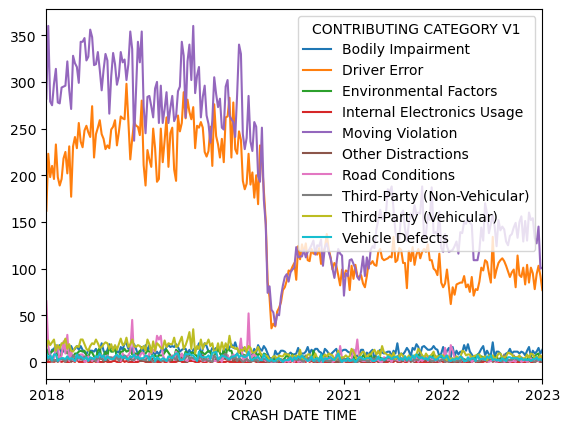

In [11]:
queens_w_pivt.plot();

In [12]:
#Converting the index as datetime index
queens_w_pivt.index = pd.to_datetime(queens_w_pivt.index)

In [13]:
#Select highest causes of collision
ts_mv = queens_w_pivt[['Moving Violation']]
ts_mv

CONTRIBUTING CATEGORY V1,Moving Violation
CRASH DATE TIME,
2018-01-07,282.0
2018-01-14,360.0
2018-01-21,279.0
2018-01-28,275.0
2018-02-04,298.0
...,...
2022-12-04,133.0
2022-12-11,127.0
2022-12-18,145.0


## Figuring it Out..

In [14]:
queens_ts_mv = ts_mv.copy()

#Differencing
queens_ts_mv['Differenced'] = queens_ts_mv.diff().dropna()
queens_ts_mv

CONTRIBUTING CATEGORY V1,Moving Violation,Differenced
CRASH DATE TIME,,
2018-01-07,282.0,NaN
2018-01-14,360.0,78.0
2018-01-21,279.0,-81.0
2018-01-28,275.0,-4.0
2018-02-04,298.0,23.0
...,...,...
2022-12-04,133.0,-21.0
2022-12-11,127.0,-6.0
2022-12-18,145.0,18.0


In [15]:
queens_ts_mv['One Shift'] = queens_ts_mv['Moving Violation'].shift(1)
queens_ts_mv

CONTRIBUTING CATEGORY V1,Moving Violation,Differenced,One Shift
CRASH DATE TIME,,,
2018-01-07,282.0,NaN,NaN
2018-01-14,360.0,78.0,282.0
2018-01-21,279.0,-81.0,360.0
2018-01-28,275.0,-4.0,279.0
2018-02-04,298.0,23.0,275.0
...,...,...,...
2022-12-04,133.0,-21.0,154.0
2022-12-11,127.0,-6.0,133.0
2022-12-18,145.0,18.0,127.0


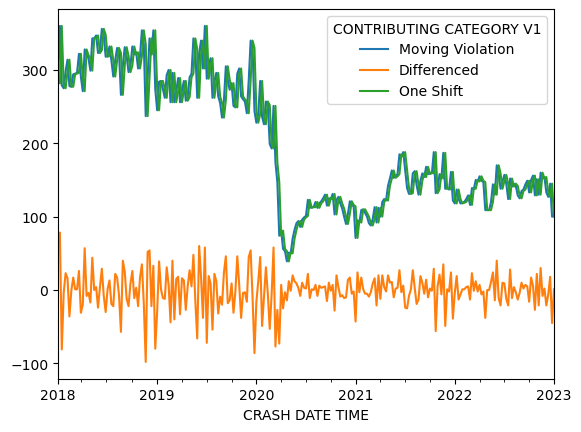

In [16]:
queens_ts_mv.plot();

## Stationarity
Before we can begin modeling, we must check the stationarity of the dataset. A stationary dataset is required for Time Series models to perform well and accurately.

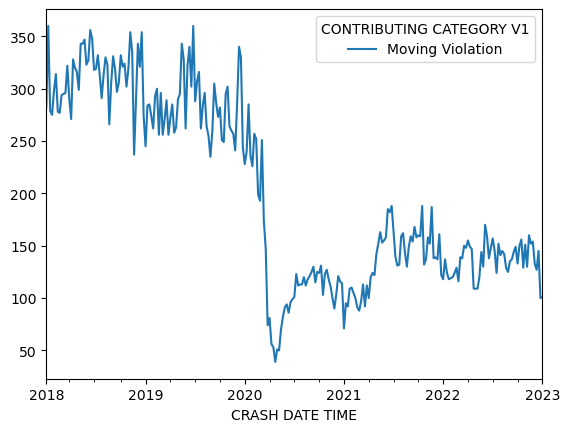

In [17]:
ts_mv.plot();

In [18]:
from statsmodels.tsa.stattools import adfuller

vtest = adfuller(ts_mv)
vtest

(-1.2972137408552507,
 0.6304460645910006,
 10,
 250,
 {'1%': -3.456780859712, '5%': -2.8731715065600003, '10%': -2.572968544},
 2241.8415282024716)

In [19]:
p_val = adfuller(ts_mv)[1]
print(f"The p-value associated with the Dickey-Fuller statistical test is {p_val},")
if p_val < 0.05:
    print(" therefore we can safely assume that the data is stationary.")
else:
    print(" therefore we cannot reject the null hypothesis that the data is \
not stationary.")

The p-value associated with the Dickey-Fuller statistical test is 0.6304460645910006,
 therefore we cannot reject the null hypothesis that the data is not stationary.


#### Differencing

In [20]:
diff = ts_mv.diff().dropna()

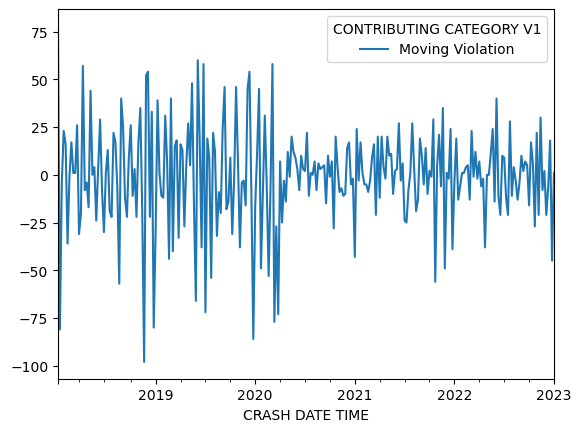

In [21]:
diff.plot();

In [22]:
difftest = adfuller(diff)
difftest

(-5.169311961086313,
 1.0153132923268659e-05,
 9,
 250,
 {'1%': -3.456780859712, '5%': -2.8731715065600003, '10%': -2.572968544},
 2233.612017667558)

In [23]:
diff_pval = adfuller(diff)[1]

print(f"The p-value associated with the Dickey-Fuller statistical test is {diff_pval},")
if diff_pval < 0.05:
    print(" therefore we can safely assume that subtracted rolling mean data is stationary.")
else:
    print(" therefore we cannot reject the null hypothesis that subtracted rolling mean data is \
not stationary.")

The p-value associated with the Dickey-Fuller statistical test is 1.0153132923268659e-05,
 therefore we can safely assume that subtracted rolling mean data is stationary.


## Train Test Split

In [24]:
# find the index which allows us to split off 20% of the data
cutoff = round(diff.shape[0]*0.8) #cut off point at 80% of the data
cutoff

208

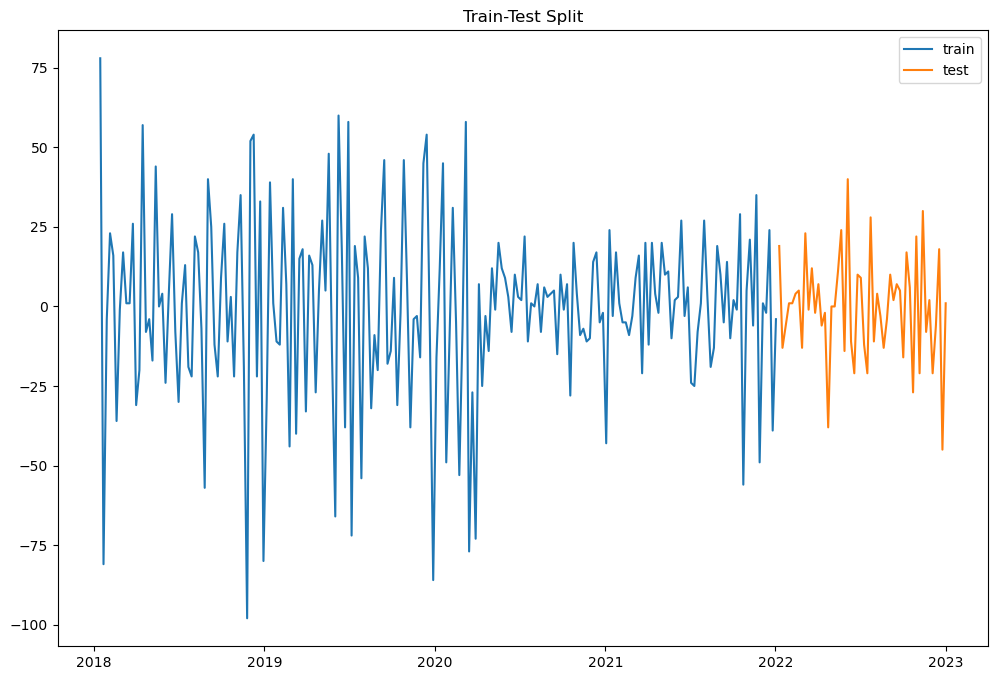

In [25]:
# Define train and test sets according to the index found above
train = diff[:cutoff] #before cut off is train set -- 80%

test = diff[cutoff:] #after cut off is the test set --20%

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.set_title('Train-Test Split');
plt.legend();

# Baseline Model
The baseline model is a naive model, which is just one shift in time by one period in time and in this case, it would be by 1 week. The metric that will be used to determine the quality and effectiveness of the model will be Root Mean Squared Error (RMSE). 

In [26]:
#Shift the prediction for the next week 
naive = train.shift(1)
naive

CONTRIBUTING CATEGORY V1,Moving Violation
CRASH DATE TIME,
2018-01-14,NaN
2018-01-21,78.0
2018-01-28,-81.0
2018-02-04,-4.0
2018-02-11,23.0
...,...
2021-12-05,-49.0
2021-12-12,1.0
2021-12-19,-2.0


In [27]:
plt.figure(figsize=(12, 8))

baseline = train.copy()
baseline['One Shift'] = baseline['Moving Violation'].shift(1)
baseline

CONTRIBUTING CATEGORY V1,Moving Violation,One Shift
CRASH DATE TIME,,
2018-01-14,78.0,NaN
2018-01-21,-81.0,78.0
2018-01-28,-4.0,-81.0
2018-02-04,23.0,-4.0
2018-02-11,16.0,23.0
...,...,...
2021-12-05,1.0,-49.0
2021-12-12,-2.0,1.0
2021-12-19,24.0,-2.0


<Figure size 1200x800 with 0 Axes>

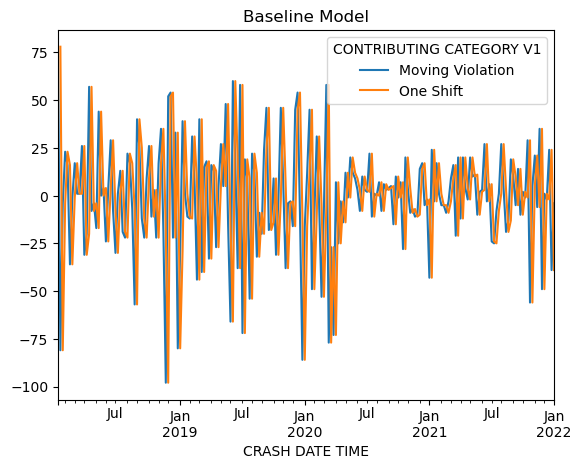

In [52]:
baseline.plot()
plt.title('Baseline Model');

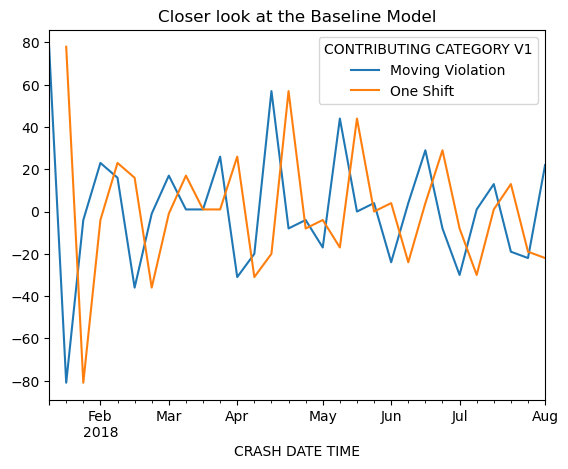

In [53]:
#A closer look
baseline[0:30].plot()
plt.title('Closer look at the Baseline Model');

In [31]:
plt.figure(figsize=(12, 8))

baseline = train.copy()
baseline['One Shift'] = baseline['Moving Violation'].shift(1)

baseline_test = baseline[1:]
baseline_test

CONTRIBUTING CATEGORY V1,Moving Violation,One Shift
CRASH DATE TIME,,
2018-01-21,-81.0,78.0
2018-01-28,-4.0,-81.0
2018-02-04,23.0,-4.0
2018-02-11,16.0,23.0
2018-02-18,-36.0,16.0
...,...,...
2021-12-05,1.0,-49.0
2021-12-12,-2.0,1.0
2021-12-19,24.0,-2.0


<Figure size 1200x800 with 0 Axes>

In [59]:
baseline_rmse = np.sqrt(mean_squared_error(baseline_test['Moving Violation'], baseline_test['One Shift']))

print(f'Baseline Model RMSE: {baseline_rmse}')

Baseline Model RMSE: 44.176304663470965


## ARIMA

In [33]:
#from pmdarima import auto_arima
#stepwise_fit = auto_arima(train, trace=True, suppress_warnings=True)

In [34]:
train

CONTRIBUTING CATEGORY V1,Moving Violation
CRASH DATE TIME,
2018-01-14,78.0
2018-01-21,-81.0
2018-01-28,-4.0
2018-02-04,23.0
2018-02-11,16.0
...,...
2021-12-05,1.0
2021-12-12,-2.0
2021-12-19,24.0


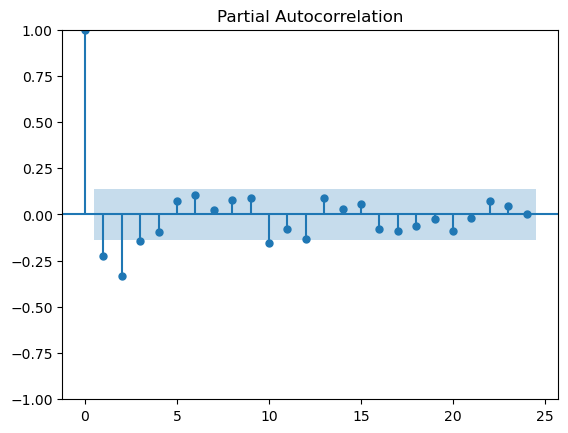

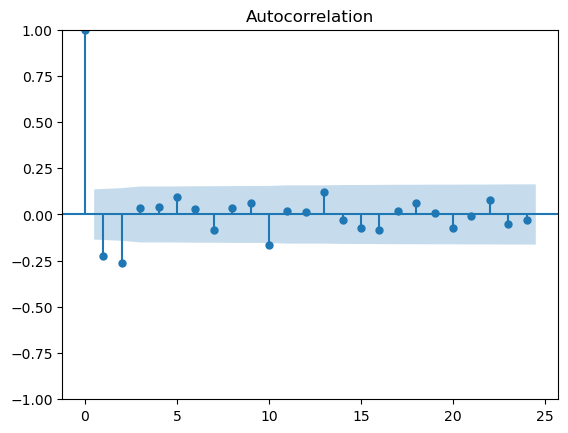

In [35]:
#Plot_pacf is used to identify the p parameter 
plot_pacf(train)

#Plot_acf is used to identify the q parameter
plot_acf(train);

p = 1 and q = 1

In [36]:
ARIMA1 = ARIMA(train['Moving Violation'], order=(1, 0, 1)).fit()
ARIMA1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       Moving Violation   No. Observations:                  208
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -975.502
Date:                Sun, 09 Apr 2023   AIC                           1959.004
Time:                        00:18:42   BIC                           1972.354
Sample:                    01-14-2018   HQIC                          1964.402
                         - 01-02-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8198      0.976     -0.840      0.401      -2.733       1.093
ar.L1          0.2328      0.129      1.808      0.071      -0.020       0.485
ma.L1         -0.6234      0.099     -6.311      0.000      -0.817      -0.430
sigma2       692.8884     56.623     12.237      0.000     581.910     803.867
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):                25.04
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               0.36   Skew:                            -0.56
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
# We put a typ='levels' to convert our predictions to remove the differencing performed.
train_pred = ARIMA1.predict(typ='levels')

In [60]:
#
ARIMA1_rmse = np.sqrt(mean_squared_error(train, train_pred))

print(f'First ARIMA Model RMSE: {ARIMA1_rmse}')

First ARIMA Model RMSE: 26.416488257455114


In [39]:
ARIMA2 = ARIMA(train, order=(2, 0, 1)).fit()

ARIMA2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       Moving Violation   No. Observations:                  208
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -970.808
Date:                Sun, 09 Apr 2023   AIC                           1951.616
Time:                        00:18:42   BIC                           1968.303
Sample:                    01-14-2018   HQIC                          1958.363
                         - 01-02-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8137      0.996     -0.817      0.414      -2.765       1.138
ar.L1          0.0017      0.148      0.012      0.991      -0.288       0.292
ar.L2         -0.2808      0.079     -3.551      0.000      -0.436      -0.126
ma.L1         -0.3502      0.153     -2.293      0.022      -0.650      -0.051
sigma2       661.7931     53.009     12.484      0.000     557.897     765.689
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                40.64
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.42   Skew:                            -0.66
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [62]:
# We put a typ='levels' to convert our predictions to remove the differencing performed.
train_pred2 = ARIMA2.predict(typ='levels')

In [63]:
#
ARIMA2_rmse = np.sqrt(mean_squared_error(train, train_pred2))
print(f'Second ARIMA Model RMSE: {ARIMA2_rmse}')

Second ARIMA Model RMSE: 25.879937034260102


In [42]:
y_pred = ARIMA2.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMA2.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"]

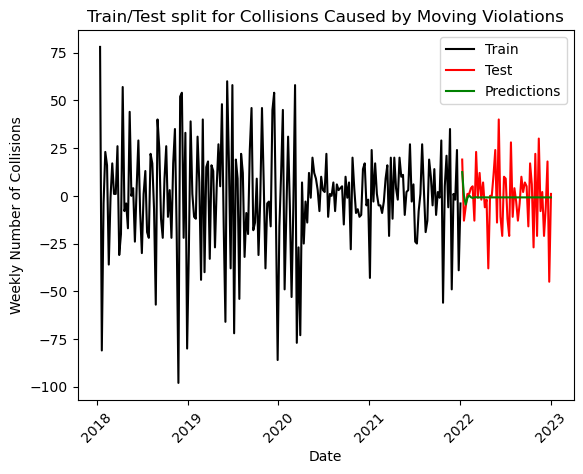

In [43]:
plt.plot(train, color = "black",label='Train')
plt.plot(test, color = "red",label='Test')
plt.ylabel('Weekly Number of Collisions')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Collisions Caused by Moving Violations")
plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.legend();